### Thread analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cycler
from matplotlib.ticker import MultipleLocator, FormatStrFormatter,AutoMinorLocator
from multiprocessing import Pool, Lock
from multiprocessing import Process, Manager
import sys
from thread import Thread

Here we load the data from http://data.nber.org/data/bargaining/

The date column is saved as a string and caused some problems, hence we convert it and save it to a new csv file to save time.

In [ ]:
'data = pd.read_csv("data/anon_bo_threads.csv",sep=',',usecols=['anon_item_id', 'anon_thread_id', 'anon_byr_id', 'anon_slr_id', 'offr_type_id', 'status_id', 'offr_price', 'src_cre_date'], converters={'src_cre_date':pd.Timestamp})
data.to_csv('data/anon_bo_threads_dates_converted.csv')

In [2]:
data = pd.read_csv("data/anon_bo_threads_dates_converted.csv",sep=',',usecols=['anon_item_id', 'anon_thread_id', 'anon_byr_id', 'anon_slr_id', 'offr_type_id', 'status_id', 'offr_price', 'src_cre_date'])

We remove all the offers that received no response.

In [3]:
data = data[data['status_id'] != 0]

We find the number of elements in each thread such that we can then analyse them separately.

In [4]:
multiplicity_threads = data.groupby(['anon_thread_id', 'anon_item_id']).count()['anon_byr_id']

We define two auxilliary functions used for creating threads and for analysing them.

In [5]:
def create_threads(index, cur, df, output):
    output[cur] = Thread(thread=df[(df['anon_item_id'] == index[1]) & (df['anon_thread_id'] == index[0])])

v_create_threads = np.vectorize(create_threads, excluded=['df', 'output'], cache=True)

In [6]:
is_decreasing = lambda a: np.all(a[:-1] >= a[1:])
is_increasing = lambda a: np.all(a[:-1] <= a[1:])

def analyse_threads(thread):
    base = thread.sold() * 4
    offers = thread.get_offers()

    buyer_offers = np.array(offers[offers['offr_type_id'] != 2]['offr_price'])
    n_buyer_offers = len(buyer_offers)
    buyer_check = (is_increasing(buyer_offers) & (n_buyer_offers > 1)) * 1

    seller_offers = np.array(offers[offers['offr_type_id'] == 2]['offr_price'])
    n_seller_offers = len(seller_offers)
    seller_check = (is_decreasing(seller_offers) & (n_seller_offers > 1)) * 2

    if base == 4:
        # if the item is sold we also consider the sold price to 
        # check if the aspiration level of a buyer or seller has decreased
        sold_price = thread.get_winning_offer()
        if n_buyer_offers > 0:
            buyer_check = (buyer_check & (buyer_offers[0] < sold_price)) * 1
        if n_seller_offers > 0:
            seller_check = ((seller_check==2)  & (seller_offers[0] > sold_price)) * 2
    else:
        if n_buyer_offers > 1:
            buyer_check = (buyer_check & (buyer_offers[0] < buyer_offers[-1])) * 1
        if n_seller_offers > 1:
            seller_check = ((seller_check==2)  & (seller_offers[0] > seller_offers[-1])) * 2
    
    current_case = base + buyer_check + seller_check
    return current_case

Now we take a maximum of MAX threads that have a number of turns in between FIRST and LAST

In [7]:
FIRST = 3
LAST = 15
MAX = 10000

total = 0
result = [[]] * (LAST - FIRST)
for j in range(FIRST,LAST):
    pool1 = Pool(5)
    sys.stdout.write("\rProgress: " + str(round((j-FIRST) * 100 / (LAST - FIRST - 1),2)) + "%")
    multiplicity_spliced = np.array(multiplicity_threads[multiplicity_threads == j][:MAX].index)
    len_mult = len(multiplicity_spliced)
    total = total + len_mult
    if len_mult == 0:
        continue
    threads = [0] * len_mult
    v_create_threads(index=multiplicity_spliced, cur=range(len_mult), df=data, output=threads)
    sys.stdout.write("\rVectorized: " + str(j))
    result[j - FIRST] = pool1.map(analyse_threads, threads)

Progress: 100.0%

we define a simple auxiliary function to count the cases

In [8]:
def count(index, output):
    output[index] = output[index] + 1

v_count = np.vectorize(count, excluded=['output'], cache=True)

In [9]:
flat_list = np.array([item for sublist in result[1:] for item in sublist])
counters = [0] * 8

v_count(index=flat_list, output=counters)

total_correct = np.sum(np.array(counters))
total_sold = np.sum(np.array(counters[4:]))
total_not_sold = np.sum(np.array(counters[:4]))

ratio_multi = np.array(counters) / [total_correct] * 100

print(ratio_multi, total_correct, total_sold, total_not_sold)

[ 2.34726153 19.27085067  2.08756451 32.87497919  0.45280506 10.51439987
  0.81904445 31.63309472] 30035 13041 16994


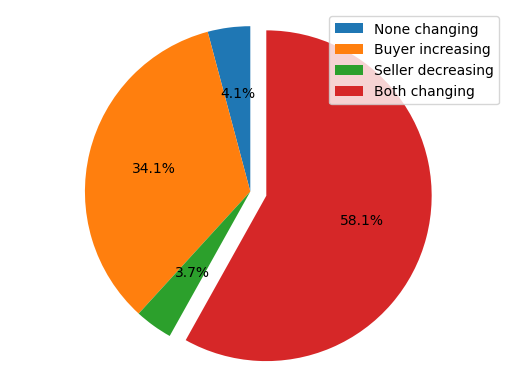

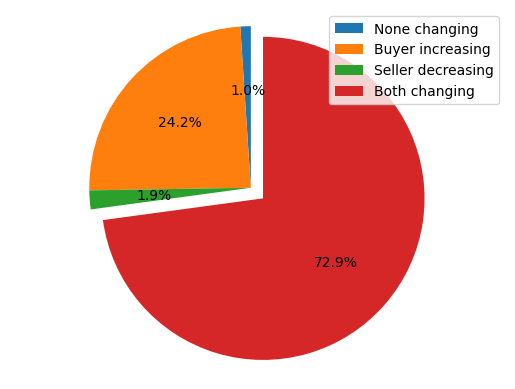

In [10]:
labels = 'None changing', 'Buyer increasing', 'Seller decreasing', 'Both changing'
explode = (0, 0, 0, 0.1)  
plot1 = ratio_multi[:4]
plot2 = ratio_multi[4:]

plt.style.use('default')

fig1, ax1 = plt.subplots()
ax1.pie(plot1, autopct='%1.1f%%', explode=explode, startangle=90)
ax1.axis('equal')  
plt.gca().set_prop_cycle(None)

plt.legend(labels=labels)

fig2, ax2 = plt.subplots()
ax2.pie(plot2, autopct='%1.1f%%', explode=explode, startangle=90)
ax2.axis('equal')  
plt.legend(labels=labels)
plt.show()

## Trend analysis

In this section we analyse the trends in offers between buyers and seller individually.

First we define these two functions that given the sequences of offers as input, give as output the arrays with the differences between offers.

In [11]:
def buyer_trend(thread, output):
    offers = thread.get_offers()
    buyer_offers = np.array(offers[offers['offr_type_id'] != 2]['offr_price'])
    last_offer = buyer_offers[0]
    i = 0
    for offer in buyer_offers[1:]:
        temp_arr = output[i]
        new_arr = temp_arr + [offer - last_offer]
        output[i] = new_arr
        last_offer = offer
        i = i+1

def seller_trend(thread, output):
    offers = thread.get_offers()
    seller_offers = np.array(offers[offers['offr_type_id'] == 2]['offr_price'])
    i = 0

    if len(seller_offers) > 0:
        last_offer = seller_offers[0]
        
    for offer in seller_offers[1:]:
        temp_arr = output[i]
        new_arr = temp_arr + [offer - last_offer]
        output[i] = new_arr
        last_offer = offer
        i = i+1

v_buyer_trend = np.vectorize(buyer_trend, excluded=['output'], cache=True)
v_seller_trend = np.vectorize(seller_trend, excluded=['output'], cache=True)

Here we consider the threads with NUM_TURNS turns and compute the differences in offers.

We then compute the mean od the difference and we plot it.

In [12]:
manager = Manager()
NUM_TURNS = 6
MAX = 10000
matrix_seller = manager.list([[]] * NUM_TURNS)
matrix_buyer = manager.list([[]] * NUM_TURNS)
pool1 = Pool(5)
multiplicity_spliced = np.array(multiplicity_threads[multiplicity_threads == NUM_TURNS][:MAX].index)
len_mult = len(multiplicity_spliced)
threads = [0] * len_mult
v_create_threads(index=multiplicity_spliced, cur=range(len_mult), df=data, output=threads)
sys.stdout.write("\rVectorized")
p1 = Process(target=v_buyer_trend, kwargs={"thread":threads, "output":matrix_buyer})
p1.start()
p2 = Process(target=v_seller_trend, kwargs={"thread":threads, "output":matrix_seller})
p2.start()
p1.join()
p2.join()

Vectorized

In [13]:
buyer_trend = [0] * NUM_TURNS
seller_trend = [0] * NUM_TURNS

i = 0
last = 0
for pippo in matrix_buyer:
    temp = np.mean(pippo)
    buyer_trend[i] = temp + last
    last = temp + last
    i = i + 1

i = 0
last = 0
for pippo in matrix_seller:
    temp = np.mean(pippo) 
    seller_trend[i] = temp + last
    last = temp + last
    i = i + 1

print(buyer_trend)
print(seller_trend)

[34.503041, 52.494401, 104.76523433333334, 107.01523433333334, 112.01523433333334, nan]
[-22.33506852055617, -33.456119303374315, nan, nan, nan, nan]


In [14]:
def plot_setup():
    plt.rcParams.update({'font.size': 10})
    colors = cycler('color',
                    [ '#2F4F4F', '#EE6666', '#3388BB', '#9988DD',
                     '#EECC55', '#88BB44', '#FFBBBB'])
    plt.rc('axes', facecolor='#E6E6E6', edgecolor='none',
           axisbelow=True, prop_cycle=colors)
    plt.rc('grid', color='w', linestyle='solid', linewidth=3)
    plt.rc('xtick', direction='out', color='black')
    plt.rc('ytick', direction='out', color='black')
    plt.rc('patch', edgecolor='#E6E6E6')
    plt.rc('lines', linewidth=2)

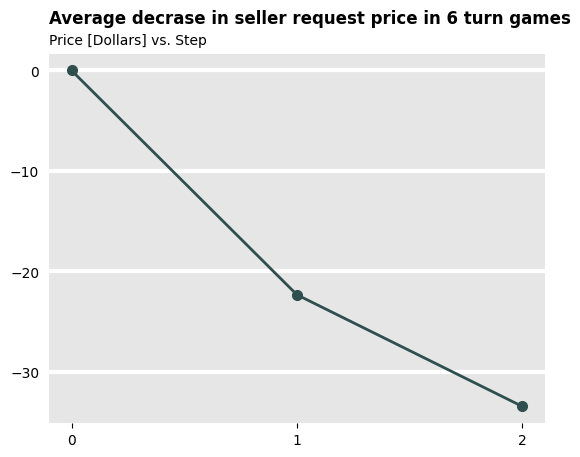

In [15]:
plot_setup()

plt.plot(range(len(seller_trend) + 1), [0] + seller_trend, '.-', markersize=14)

plt.gcf().text(0.125, 0.9,"Price [Dollars] vs. Step", fontsize=10)
title = "Average decrase in seller request price in " + str(NUM_TURNS) + " turn games"
plt.title(title, loc='left', y=1.06, fontsize=12, weight='bold')


ax = plt.gca()
ax.grid(which='major', axis='y')
plt.yticks(fontsize=10)
plt.axes().tick_params(left=False)
plt.xticks(fontsize=10, rotation=0)
plt.tick_params(
    axis='x',          
    which='both',     
    bottom=True,   
    top=False,       
    labelbottom=True) 
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(10))
plt.show()

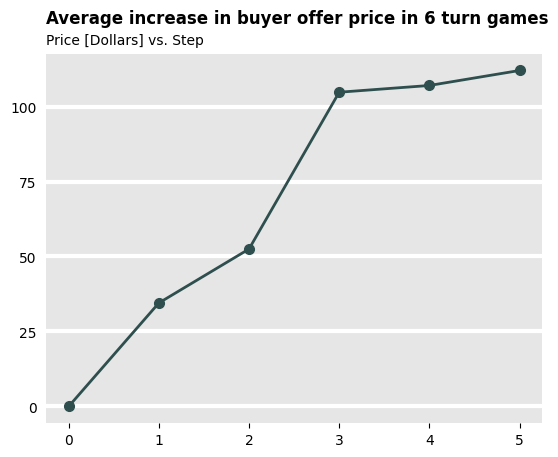

In [16]:
plot_setup()

plt.plot(range(len(buyer_trend) + 1), [0] + buyer_trend, '.-', markersize=14)

plt.gcf().text(0.125, 0.9,"Price [Dollars] vs. Step", fontsize=10)
title = "Average increase in buyer offer price in " + str(NUM_TURNS) + " turn games"
plt.title(title, loc='left', y=1.06, fontsize=12, weight='bold')


ax = plt.gca()
ax.grid(which='major', axis='y')
plt.yticks(fontsize=10)
plt.axes().tick_params(left=False)
plt.xticks(fontsize=10, rotation=0)
plt.tick_params(
    axis='x',         
    which='both',     
    bottom=True,      
    top=False,        
    labelbottom=True)  
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(25))
plt.show()